In [1]:
import gym
import numpy as np
from tqdm import tqdm
import torch
import wandb

from fractal_zero.config import FMCConfig
from fractal_zero.search.fmc import FMC
from fractal_zero.models.prediction import FullyConnectedPredictionModel
from fractal_zero.vectorized_environment import (
    RayVectorizedEnvironment,
    VectorizedDynamicsModelEnvironment,

)
from fractal_zero.trainers.online import OnlineFMCPolicyTrainer

from fractal_zero.tests.test_vectorized_environment import build_test_joint_model

In [2]:
NUM_WALKERS = 64

class CartpolePolicy(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(4, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 2),
        )

    def forward(self, observations, with_randomness: bool = False, argmax: bool = True):
        observations = torch.tensor(observations).float()

        y = self.net(observations)

        if with_randomness:
            # center = embeddings.std()
            center = y.var()
            centered_uniform_noise = (torch.rand_like(y) * center) - (center / 2)
            y += centered_uniform_noise

        # TODO: refac
        if argmax:
            return torch.argmax(y, dim=-1)
        return y

    def parse_actions(self, actions):
        return actions.tolist()

policy_model = CartpolePolicy()

In [3]:
# optimizer = torch.optim.SGD(policy_model.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.Adam(policy_model.parameters(), lr=0.01, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
policy_trainer = OnlineFMCPolicyTrainer("CartPole-v0", policy_model, optimizer, NUM_WALKERS)

/home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
2022-09-27 02:01:25,928	INFO worker.py:1518 -- Started a local Ray instance.


In [4]:
wandb.init(project="fz-policy-trainer-epsilon-greedy")

/home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
(pid=2064449) WARNING: CPU random generator seem to be failing, disabling hardware random number generation
(pid=2064449) WARNING: RDRND generated: 0xffffffff 0xffffffff 0xffffffff 0xffffffff
(pid=2064450) WARNING: CPU random generator seem to be failing, disabling hardware random number generation
(pid=2064450) WARNING: RDRND generated: 0xffffffff 0xffffffff 0xffffffff 0xffffffff
(pid=2064445) WARNING: CPU random generator seem to be failing, disabling hardware random number generation
(pid=2064445) WARNING: RDRND generated: 0xffffffff 0xffffffff 0xffffffff 0xffffffff
(pid=2064452) WARNING: CPU random generator seem to be failing, disabling hardware random number generation
(pid=2064452) WARNING: RDRND generated: 0xffffffff 0xffffffff 0xffffffff 0xffffffff
(p

In [5]:
num_episodes = 100
train_steps_per_episode = 2
eval_every = 20
max_steps = 32

for _ in range(num_episodes):
    policy_trainer.generate_episode_data(max_steps)

    for i in range(train_steps_per_episode):
        policy_trainer.train_on_latest_episode()

        if i % eval_every == 0:
            policy_trainer.evaluate_policy(max_steps)

    lr_scheduler.step()

(_RayWrappedEnvironment pid=2064703) /home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
(_RayWrappedEnvironment pid=2064703)   logger.warn(
(_RayWrappedEnvironment pid=2064703) /home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
(_RayWrappedEnvironment pid=2064703)   deprecation(
(_RayWrappedEnvironment pid=2064703) /home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. T

In [6]:
policy_trainer.fmc.clone_receives

tensor([[18],
        [18],
        [26],
        [25],
        [22],
        [21],
        [24],
        [24],
        [23],
        [25],
        [23],
        [25],
        [23],
        [18],
        [21],
        [26],
        [23],
        [23],
        [24],
        [21],
        [19],
        [25],
        [21],
        [25],
        [23],
        [23],
        [24],
        [23],
        [25],
        [24],
        [21],
        [22],
        [21],
        [20],
        [21],
        [24],
        [21],
        [21],
        [24],
        [18],
        [24],
        [24],
        [21],
        [19],
        [24],
        [22],
        [21],
        [22],
        [19],
        [21],
        [18],
        [20],
        [21],
        [25],
        [21],
        [25],
        [22],
        [21],
        [22],
        [21],
        [18],
        [21],
        [21],
        [25]])

/home/nollyd/anaconda3/envs/gailzero/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(


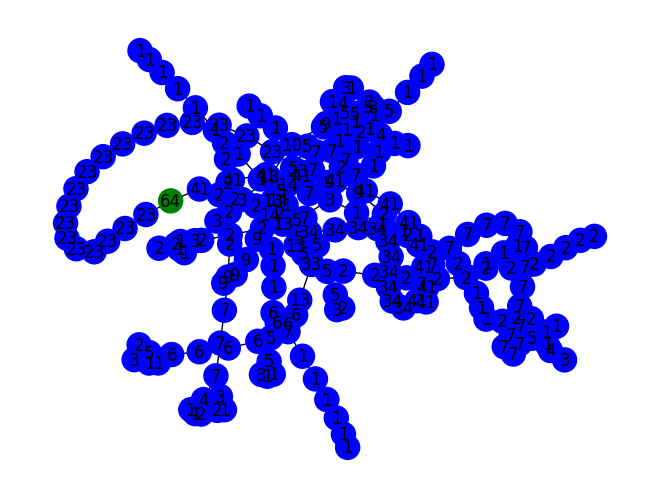

In [7]:
policy_trainer.fmc.tree.render()

In [9]:
str(policy_trainer.fmc.tree.g)

'Graph with 229 nodes and 228 edges'